# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
import math  
from scipy.misc import derivative
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox


## Define car parameters

In [3]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [6]:
#Define the distance equation based on "Jiménez-Meza, A., Arámburo-Lizárraga, J., & de la Fuente, E. (2013). Framework for estimating travel time, distance, speed, and street segment level of service (los), based on GPS data. Procedia Technology, 7, 61-70."

def distance(lon1,lon2,lat1,lat2): 
    b = 69.1 * (lat2 - lat1)
    e = 69.1 * (lon2 - lon1) * np.cos(lat1/57.3)
    d = math.sqrt((b ** 2) + (e ** 2)) * 1609.344
    return d

#define gradient equation
def gradient(height,distance):
    return height/distance


## Define engine power (KW) equation
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        speed = speed/3.6 #convert to m/s
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000, power/speed]
    else:
        resistance =(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [P_idle, resistance]
    
# interpolate to find efficiency values based on driving resistance
def interpolation(x):
    A = [-2000, 2000]
    B = [0.1, 0.4]
    f = interpolate.interp1d(A, B)
    efficiency = f(x)
    return efficiency

## Fuel consumption ewuation
def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

# Request elevation values from an open source (opentopodata.org)
import time
import requests as req,json
url = 'https://api.opentopodata.org/v1/eudem25m?locations='
def generate_parms(s,e):
    lats= list(one_track[s:e]['geometry'].y)
    lngs = list(one_track[s:e]['geometry'].x)
    track_coords = [c for c in zip(lats, lngs)]
    format_str=list(map(lambda x : str(x[0])+','+str(x[1])+'|', track_coords)) 
    concat_str = ''.join(format_str)
    return concat_str

def request(link):
    elevation = req.request('GET',link)
    results = elevation.json()['results']
    status =elevation.json()['status']
    if status=='OK':
        h = list(map(lambda x : x['elevation'], results))
    else:
        h= None
    return h

## Estimate fuel consumption/Co2 emissions for tracks in dataframe

In [7]:
tracks = pd.DataFrame(columns=track_df.columns)
for i in range (10,30):
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    # estimate the len of data
    batch = [int(len(one_track)/100),len(one_track)%100]
    elevation=[]
    # get elevation values
    for i in range(batch[0]+1):
        #create requeest 100 parameter 
        s = i*100
        e = (i+1)*100
        if i<batch[0]+1:
            --e 
        else:
            e= e+batch[1]

        parms= generate_parms(s,e)
        access= url+parms
        part = request(access)
        if part==None:
            part=[np.nan]*(e+1-s)    
        elevation.extend(part)
        time.sleep(1)
    one_track['elevation']=elevation
    temp=one_track[one_track['elevation'].isnull()==True]
    if len(temp)> 0:
        for i in temp.index:
            one_track.loc[i,'elevation']=one_track.loc[i,'GPS Altitude.value']
    
    # claculate the gradient
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        one_track.loc[i,'gradient']= grade
    
    ## Add interval time
    j = 5
    for i in one_track.index:
        one_track.loc[i, 'time_interval'] = j
        j = j+5
    # Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] / 3.6
    
    # calculate acceleration
    time_interval = np.array(one_track['time_interval'])
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        else:
            one_track.loc[i, 'Acceleration'] = (one_track.loc[i+1, 'speed'] - one_track.loc[i, 'speed'])/5
    
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
            one_track.loc[i, 'driving_resistance'] = ep[1]
    
    #Calculates Engine Power for Volks
    for i in one_track.index:
        ep = engine_power(volks,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_volks'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'eng_pw_volks'] = ep[0]
            one_track.loc[i, 'driving_resistance_volks'] = ep[1]
    
    # calculate the efficiency based on the driving resistance         
    for i in one_track.index:
        res = one_track.loc[i, 'driving_resistance']
        res_volks = one_track.loc[i, 'driving_resistance_volks']
        if (res >= 2000 or res <= -2000):
            one_track.loc[i,'efficiency'] = 0.3
        else:
            one_track.loc[i, 'efficiency'] = interpolation(res)
        if (res_volks >= 2000 or res_volks <= -2000):
            one_track.loc[i,'efficiency_volks'] = 0.3
        else:
            one_track.loc[i, 'efficiency_volks'] = interpolation(res_volks)            
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, one_track.loc[i,'efficiency']) 
        one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for Volks (diesel)
    for i in one_track.index:
        volks_cons = fuel_consumption(one_track.eng_pw_volks[i],H_d, one_track.loc[i, 'efficiency_volks']) 
        one_track.loc[i, 'Consumption_volks_diesel'] = volks_cons    ## liters / hour
        one_track.loc[i, 'CO2_volks_diesel'] = volks_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

<ipython-input-7-56b10fe7aecf>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_track['elevation']=elevation
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\scipy\interpolate\interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
<ipython-input-6-261a5136fd92>:11: RuntimeWarning: invalid value encountered in double_scalars
  return height/distance


## Filter the data

In [8]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption.value', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel','geometry' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[11]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

time     speed  time_interval  Acceleration  elevation  \
0     2019-12-29T12:11:19  3.802064            5.0      0.148187  -0.312093   
1     2019-12-29T12:11:25  4.543000           10.0     -0.180077  -0.209130   
2     2019-12-29T12:11:30  3.642615           15.0     -0.702525  -0.176606   
3     2019-12-29T12:11:35  0.129990           20.0     -0.025998  -0.065007   
4     2019-12-29T12:11:40  0.000000           25.0      0.000000  -0.066134   
...                   ...       ...            ...           ...        ...   
1722  2019-12-29T14:36:43  0.000000         8615.0      0.047910  62.675255   
1723  2019-12-29T14:36:48  0.239552         8620.0     -0.047910  62.675323   
1724  2019-12-29T14:36:53  0.000000         8625.0      0.000000  62.666435   
1725  2019-12-29T14:36:58  0.000000         8630.0      0.000000  62.666382   
1726  2019-12-29T14:37:03  0.000000         8635.0           NaN  62.669178   

      gradient  engine_power  driving_resistance  efficiency  eng_pw_volks  \
0     0.006931      0.653700          618.958972    0.296422      0.684255   
1     0.001434      0.057864           45.852741    0.253439      0.060647   
2     0.010470      2.000000         -633.271975    0.202505      2.000000   
3    -0.012105      0.002786           77.167117    0.255788      0.002916   
4    -0.020266      2.000000           -3.949228    0.249704      2.000000   
...        ...           ...                 ...         ...           ...   
1722  0.000137      2.000000          368.178855    0.277613      2.000000   
1723 -0.007448      0.007508          112.829832    0.258462      0.007858   
1724 -0.000309      2.000000          289.754600    0.271732      2.000000   
1725  0.003368      2.000000          343.854834    0.275789      2.000000   
1726       NaN      2.000000                 NaN         NaN      2.000000   

      Consumption.value  Consumption_Gasoline  CO2_Gasoline  \
0              2.201733              0.250603      0.598940   
1              3.186081              0.025945      0.062008   
2              1.890531              1.122309      2.682318   
3              1.771329              0.001238      0.002959   
4              1.833710              0.910169      2.175305   
...                 ...                   ...           ...   
1722           1.685962              0.818666      1.956612   
1723           2.153064              0.003301      0.007889   
1724           1.690632              0.836387      1.998965   
1725           1.793028              0.824082      1.969555   
1726                NaN                   NaN           NaN   

      Consumption_volks_diesel  CO2_volks_diesel  
0                     0.231476          0.622669  
1                     0.024156          0.064979  
2                          NaN               NaN  
3                     0.001150          0.003095  
4                     0.809084          2.176436  
...                        ...               ...  
1722                  0.724341          1.948477  
1723                  0.003066          0.008249  
1724                  0.740691          1.992458  
1725                  0.729334          1.961909  
1726                       NaN               NaN  

[1727 rows x 15 columns]

## Comprasion between estimated fuel consumption & ODM values for one route

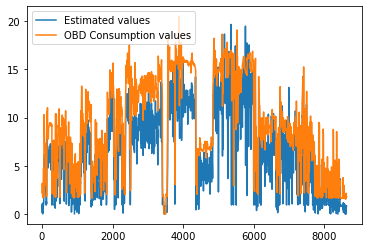

In [62]:
f, axarr = plt.subplots(1)
x = time_interval = np.array(one_track['time_interval'])
y1 = np.array(one_track['Consumption_Gasoline'])
y2 = np.array(one_track['Consumption.value'])
one = axarr.plot(x,y1, label="Estimated values")
two = axarr.plot(x,y2, label="OBD Consumption values" )
axarr.legend()
plt.show()

### The relationship between consumption and speed/acceleration

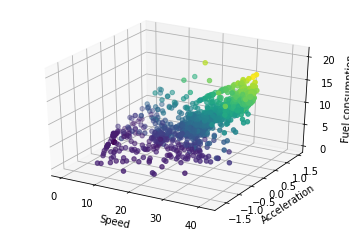

In [9]:
#set axes
ax = plt.axes(projection='3d')
zdata = np.array(one_track['Consumption.value'])
xdata = np.array(one_track['speed']) 
ydata = np.array(one_track['Acceleration'])

#set labels
ax.set_xlabel('Speed')
ax.set_ylabel('Acceleration')
ax.set_zlabel('Fuel consumption')

ax.scatter3D(xdata, ydata, zdata, c=zdata);


## Plot different variables for one track

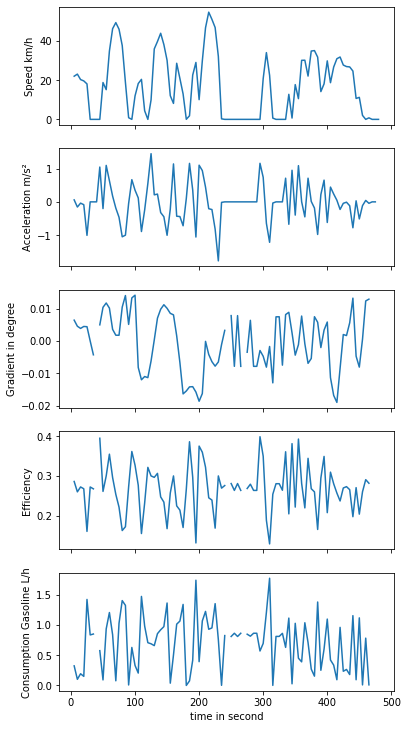

In [10]:
## select on track
one_track_id = tracks['track.id'].unique()[7]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

f, axarr = plt.subplots(5, sharex=True)
figsize=(8, 6)
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
efficiency = np.array(one_track['efficiency']) 



axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , efficiency)
axarr[4].plot(time_interval , Consumption_Gasoline)



axarr[4].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
axarr[3].set_ylabel('Efficiency')
axarr[4].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)


## To look for the most efficient driving behaviour on a route

In [11]:
one_track_id = tracks['track.id'].unique()[7]
track = tracks[tracks['track.id'] == one_track_id]
test_track = track[['time','time_interval', 'speed', 'Acceleration', 'elevation','gradient',]]


### Driving behaviour on the route in the city 

In the following section, differnt speed profile (constant speed) tested to check the fuel instantinous fuel consumption on the route at different speed, and the accuumulated consumption on a route with the time.

In [ ]:
# constant speed value

speed = [10, 20, 30, 40, 50]
acceleration = [0]
columns = ['consumption_10', 'consumption_20', 'consumption_30', 'consumption_40', 'consumption_50']
accumulate_consumption = ['accumulate_10', 'accumulate_20', 'accumulate_30', 'accumulate_40', 'accumulate_50']
cumulated = 0
cumulated_fuel = []
for x in range(0,5):
    #test_track.insert(2,columns[x], True)
    for i in test_track.index:
        ep = engine_power(car,0.02,test_track.gradient[i],speed[x],acceleration[0])
        if ep[0] < 0:
            test_track.loc[i, 'engine_power'] = P_idle
            test_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            test_track.loc[i, 'engine_power'] = ep[0]
            test_track.loc[i, 'driving_resistance'] = ep[1]
    for i in test_track.index:
        res = test_track.loc[i, 'driving_resistance']
        if (res >= 2000 or res <= -2000):
            test_track.loc[i,'efficiency'] = 0.3
            
        else:
            test_track.loc[i, 'efficiency'] = interpolation(res)
                   
    ## Instantaneous/Cumulated Fuel consumption
    for i in test_track.index:
        car_cons = fuel_consumption(test_track.engine_power[i],H_g, test_track.loc[i,'efficiency']) 
        test_track.loc[i, columns[x]] = car_cons
        value = test_track.loc[i, columns[x]]
        if value >=0:
            cumulated += value/720 #convert time unit from 1 hr to 5 seconds
        
        test_track.loc[i, accumulate_consumption[x]] = cumulated
    ## Cumulated Fuel Consumption
    cumulated_fuel.append(cumulated)
    cumulated = 0


In [13]:
test_track

time  time_interval consumption_50 consumption_40  \
0   2020-01-05T15:52:01            5.0        2.54544        1.93814   
1   2020-01-05T15:52:06           10.0         2.4091        1.82761   
2   2020-01-05T15:52:11           15.0        2.35986        1.78769   
3   2020-01-05T15:52:16           20.0        2.40398        1.82345   
4   2020-01-05T15:52:21           25.0        2.39863        1.81912   
..                  ...            ...            ...            ...   
91  2020-01-05T15:59:41          460.0        2.96264        2.27629   
92  2020-01-05T15:59:46          465.0         3.0005        2.30697   
93  2020-01-05T15:59:51          470.0            NaN            NaN   
94  2020-01-05T15:59:56          475.0        1.94051        1.44764   
95  2020-01-05T16:00:01          480.0            NaN            NaN   

   consumption_30 consumption_20 consumption_10     speed  Acceleration  \
0         1.39563        0.90257        0.44288  6.121902      0.059594   
1         1.31187       0.846313       0.414625  6.419874     -0.154965   
2         1.28162        0.82599       0.404417  5.645050     -0.038176   
3         1.30872       0.844197       0.413562  5.454171     -0.085098   
4         1.30544       0.841991       0.412454  5.028682     -1.005736   
..            ...            ...            ...       ...           ...   
91        1.65186        1.07465       0.529299  0.000000      0.043027   
92         1.6751        1.09026       0.537138  0.215135     -0.043027   
93            NaN            NaN            NaN  0.000000      0.000000   
94        1.02387       0.652851       0.317452  0.000000      0.000000   
95            NaN            NaN            NaN  0.000000           NaN   

    elevation  gradient  engine_power  driving_resistance  efficiency  \
0   60.231903  0.006452      6.370532          458.678313    0.284401   
1   60.448933  0.004566      5.985211          430.935203    0.282320   
2   60.586002  0.003892      5.847421          421.014279    0.281576   
3   60.652843  0.004496      5.970835          429.900125    0.282243   
4   60.794601  0.004423      5.955846          428.820944    0.282162   
..        ...       ...           ...                 ...         ...   
91  58.911308  0.012399      7.585771          546.175522    0.290963   
92  58.920212  0.012953      7.698825          554.315383    0.291574   
93  58.947453       NaN           NaN                 NaN         NaN   
94  58.947453 -0.001709      4.702768          338.599311    0.275395   
95  58.947277       NaN           NaN                 NaN         NaN   

    accumulate_10  accumulate_20  accumulate_30  accumulate_40  accumulate_50  
0        0.442880       0.902570       1.395632       1.938136       2.545436  
1        0.857505       1.748883       2.707504       3.765747       4.954536  
2        1.261922       2.574873       3.989120       5.553434       7.314394  
3        1.675484       3.419070       5.297843       7.376889       9.718370  
4        2.087938       4.261061       6.603281       9.196009      12.116998  
..            ...            ...            ...            ...            ...  
91      29.410721      60.410170      94.562761     133.385062     178.323767  
92      29.947859      61.500425      96.237865     135.692037     181.324266  
93      29.947859      61.500425      96.237865     135.692037     181.324266  
94      30.265310      62.153276      97.261735     137.139678     183.264772  
95      30.265310      62.153276      97.261735     137.139678     183.264772  

[96 rows x 19 columns]

### Plot Instantaneous Fuel consumption at different speed profile

The following graph shows how the fuel consumption affected by change the speed, it is obvious that decrasing the speed in the city from 50km/h to 30km/h would help save fuel and reduce CO2 emissios. 

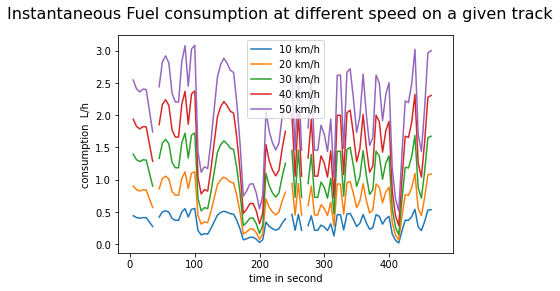

In [36]:
f, axarr = plt.subplots(1)

x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['consumption_10']) 
consumption_20 = np.array(test_track['consumption_20'])
consumption_30 = np.array(test_track['consumption_30'])
consumption_40 = np.array(test_track['consumption_40'])
consumption_50 = np.array(test_track['consumption_50']) 

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_20, label="20 km/h" )
three = axarr.plot(x,consumption_30, label="30 km/h")
four = axarr.plot(x,consumption_40, label="40 km/h")
five = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('consumption  L/h')
f.suptitle('Instantaneous Fuel consumption at different speed on a given track', fontsize=16)
axarr.legend()
plt.show()

### Plot cumulated Fuel consumption against speed profile

The next plot shows the behavouir of accumulated fuel consumption against speed, you can notice that increasing the speed on the route leads to increase the accumulated fuel consumption on the route.


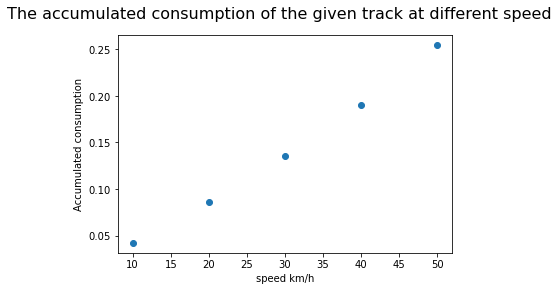

In [38]:
f, axarr = plt.subplots(1)
x = np.array(speed)
y = np.array(cumulated_fuel) 
one = axarr.scatter(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('Accumulated consumption')
f.suptitle('The accumulated consumption of the given track at different speed', fontsize=16)
plt.show()

## Plot accumulate Fuel consumption on a route against specific time

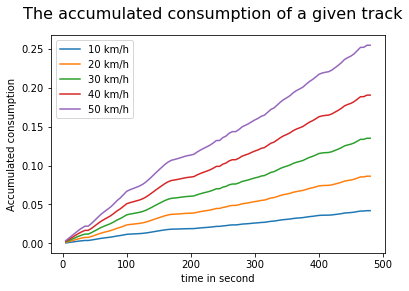

In [40]:
f, axarr = plt.subplots(1)
f.suptitle('The accumulated consumption of a given track', fontsize=16)
x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['accumulate_10'])
consumption_20 = np.array(test_track['accumulate_20'])
consumption_30 = np.array(test_track['accumulate_30'])
consumption_40 = np.array(test_track['accumulate_40'])
consumption_50 = np.array(test_track['accumulate_50'])

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_20, label="20 km/h" )
three = axarr.plot(x,consumption_30, label="30 km/h")
four = axarr.plot(x,consumption_40, label="40 km/h")
five = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('Accumulated consumption')
axarr.legend()
plt.show()

## The most efficient route

The following map shows different routes, visualized depending on the fuel consumption to let the user now which is the most efficient route. 

In [70]:
import plotly.express as px
tracks['lat'] = tracks['geometry'].apply(lambda coord: coord.y)
tracks['lng'] = tracks['geometry'].apply(lambda coord: coord.x)
tracks.dropna()
#print (tracks)
some_track_flat = tracks[tracks['track.id'] == one_track_id]
#print(some_track_flat)
fig = px.scatter_mapbox(tracks, lat="lat", lon="lng", color="Consumption_Gasoline")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## The fastest/shortest route


The following network build based on OSM for the same study area, then used the nwteork to find the fastest route between two points (based on time) if the speed value was the maximun speed allowed on the route.

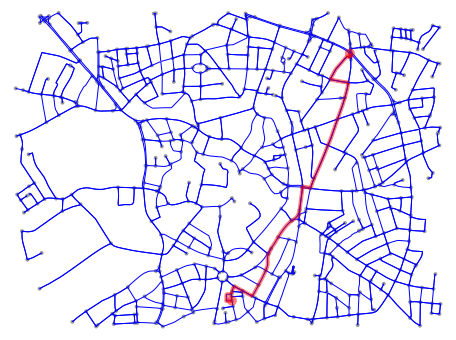

In [190]:
import osmnx as ox
import networkx as nx

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
orig = list(G)[1]
dest = list(G)[-1]

hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

route1 = nx.shortest_path(G, orig, dest, weight='time')
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route1, edge_color= 'blue')

## The most efficient route & The fastest route

The following cells used to match the routes with OSM, and assign the estimated CO2 emissions on the road to the OSM segment, then build a network to compare between the fastest route and the most efficient route between two points.

One limitation of this method, the routes not cover the whole OSM that leads to assign (0) CO2 emissions for edges not cover by the routes, that affect the network ad find the most efficient route.  

In [191]:
## extract the OSM network and assign the CO2 emmisions

nodes, streets = ox.graph_to_gdfs(G)

ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color='#333333', edge_width=1, edge_opacity=1)
streets1 = streets
allstreets = pd.DataFrame(columns=streets.columns)
l = [0] * len(streets)
for i in range (0,20):
    one_track_id = tracks['track.id'].unique()[i]
    one_track = tracks[tracks['track.id'] == one_track_id]
    for i in one_track.index:
        
        lat= one_track.loc[i,'geometry'].y
        lng= one_track.loc[i,'geometry'].x
        u1,v1,key = (ox.get_nearest_edge(G, (lat, lng)))
        index = streets1[(streets1.u ==u1) & (streets1.v ==v1)].index
        num = index.array[0]
        value = one_track.loc[i,'CO2_Gasoline']
        if value>= 0:
            l[num]+= value
     

### Graph of OSM network 

In [211]:
graph2 = ox.graph_from_gdfs(nodes, streets1)
edge_colors = ox.plot.get_edge_colors_by_attr(graph2, 'co2', num_bins=5, cmap='viridis', start=0, stop=1, na_color='none')

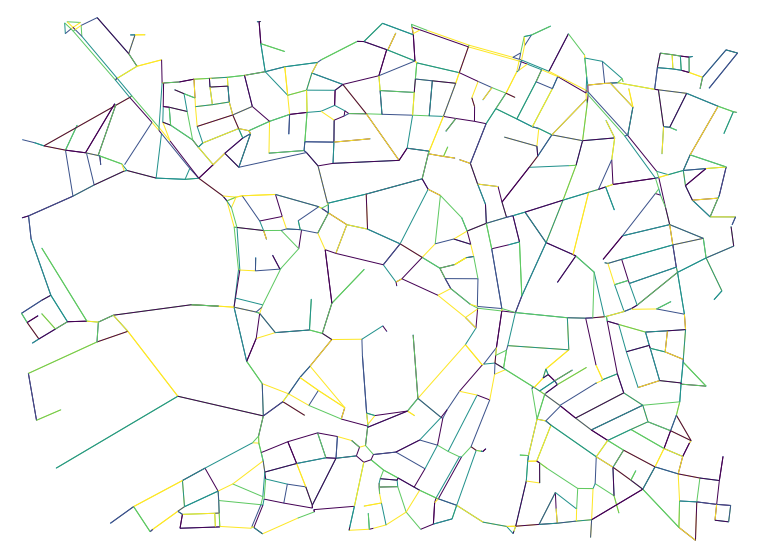

In [212]:
fig, ax = ox.plot_graph(ox.project_graph(graph2), fig_height=10, node_size=1, edge_color=edge_colors, dpi=600)


### The most efficient route

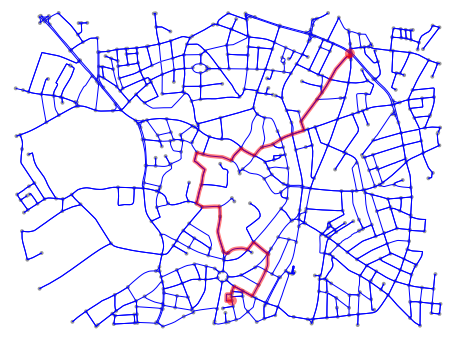

In [213]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route2 = nx.shortest_path(graph2, orig, dest, weight='co2')

fig, ax = ox.plot_graph_route(graph2, route2, edge_color= 'blue')

### The fastest route

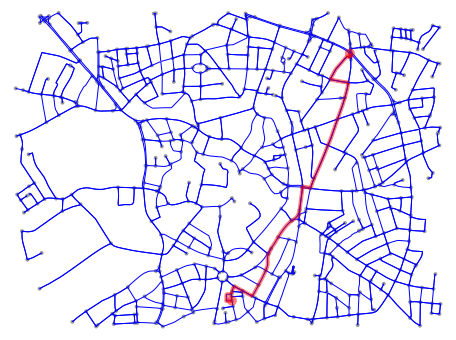

In [182]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route1 = nx.shortest_path(graph2, orig, dest, weight='time')

fig, ax = ox.plot_graph_route(graph2, route1, edge_color= 'blue')